In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
import calmap
import calplot 

In [2]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]

In [3]:
from collections import Counter
raw_data = {}

raw_data['corona'] = pd.read_csv(corona,sep = '\t')
raw_data['metadata'] = pd.read_csv(meta,sep = '\t')
raw_data['shape'] = pd.read_csv(shape,sep = '\t')
raw_data['weather'] = pd.read_csv(weather,sep = '\t')

In [4]:
HEADERS = ['corona','weather']
for i in HEADERS:
    print(i +"  \tDataFrame shape: " + str(raw_data[i].shape))

corona  	DataFrame shape: (5602, 4)
weather  	DataFrame shape: (14904, 9)


In [5]:
def check_null_values(file):
    if raw_data[file].isnull().values.any():
        print('There are null values in the dataset')
    else:
        print('There are no null values in the dataset')

In [6]:
check_null_values('corona')

There are no null values in the dataset


date
2020-02-13    276.551573
2020-02-13    276.844633
2020-02-13    276.227143
2020-02-13    275.583053
2020-02-13    276.237452
                 ...    
2020-11-14    283.769570
2020-11-14    283.837352
2020-11-14    283.909275
2020-11-14    284.662583
2020-11-14    283.884262
Name: TemperatureAboveGround, Length: 4416, dtype: float64


,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Temp_Celsius
date,,,,,,,,
2020-02-13,83.550416,9.232296e+05,2.361713e+06,276.080346,0.005425,3.045868,4.677214,2.930346
2020-02-14,87.038057,1.189954e+06,2.385722e+06,277.740734,0.001314,1.875386,3.260335,4.590734
2020-02-15,78.429711,2.849352e+06,2.388378e+06,279.481576,0.000151,3.958054,4.619486,6.331576
2020-02-16,63.587472,7.130768e+05,2.360307e+06,284.575068,0.004384,3.224329,7.988258,11.425068
2020-02-17,73.292063,1.628548e+06,2.373769e+06,280.940914,0.003836,3.951442,6.621854,7.790914
...,...,...,...,...,...,...,...,...
2020-11-10,93.142306,1.180869e+06,2.408910e+06,278.386766,0.000058,1.032930,2.424941,5.236766
2020-11-11,92.949727,3.166723e+05,2.403508e+06,279.602605,0.000346,0.473817,2.025096,6.452605
2020-11-12,89.265265,1.284097e+06,2.390391e+06,280.757227,0.001018,1.994895,3.203011,7.607227


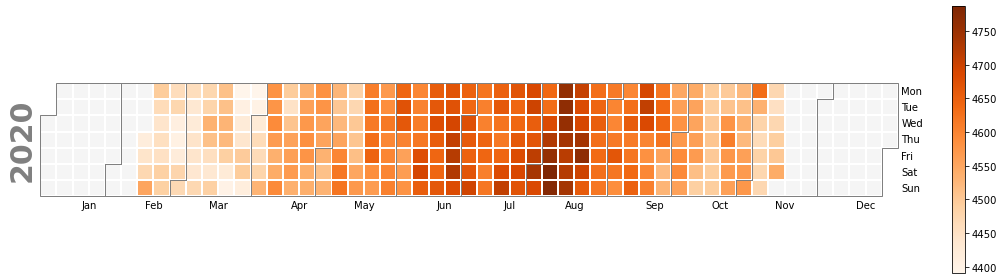

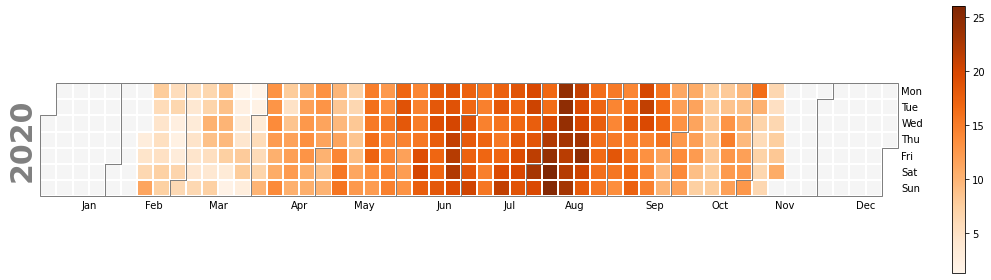

In [42]:
weather_data_de = raw_data["weather"][raw_data["weather"]["iso3166-2"].str.startswith("DE")]
ww = pd.DatetimeIndex(weather_data_de['date'])
ww
s = weather_data_de.set_index(ww)
#calmap.yearplot(s['TemperatureAboveGround'])
a = pd.Series(s['TemperatureAboveGround'])
print(a)
calplot.calplot(a, cmap='Oranges',colorbar = True,figsize = (16,4));
celsius = pd.DataFrame(weather_daily['TemperatureAboveGround'].subtract(273.15))
weather_daily['Temp_Celsius'] = celsius
calplot.calplot(weather_daily['Temp_Celsius'], cmap='Oranges',colorbar = True,figsize = (16,4));
weather_daily

In [ ]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

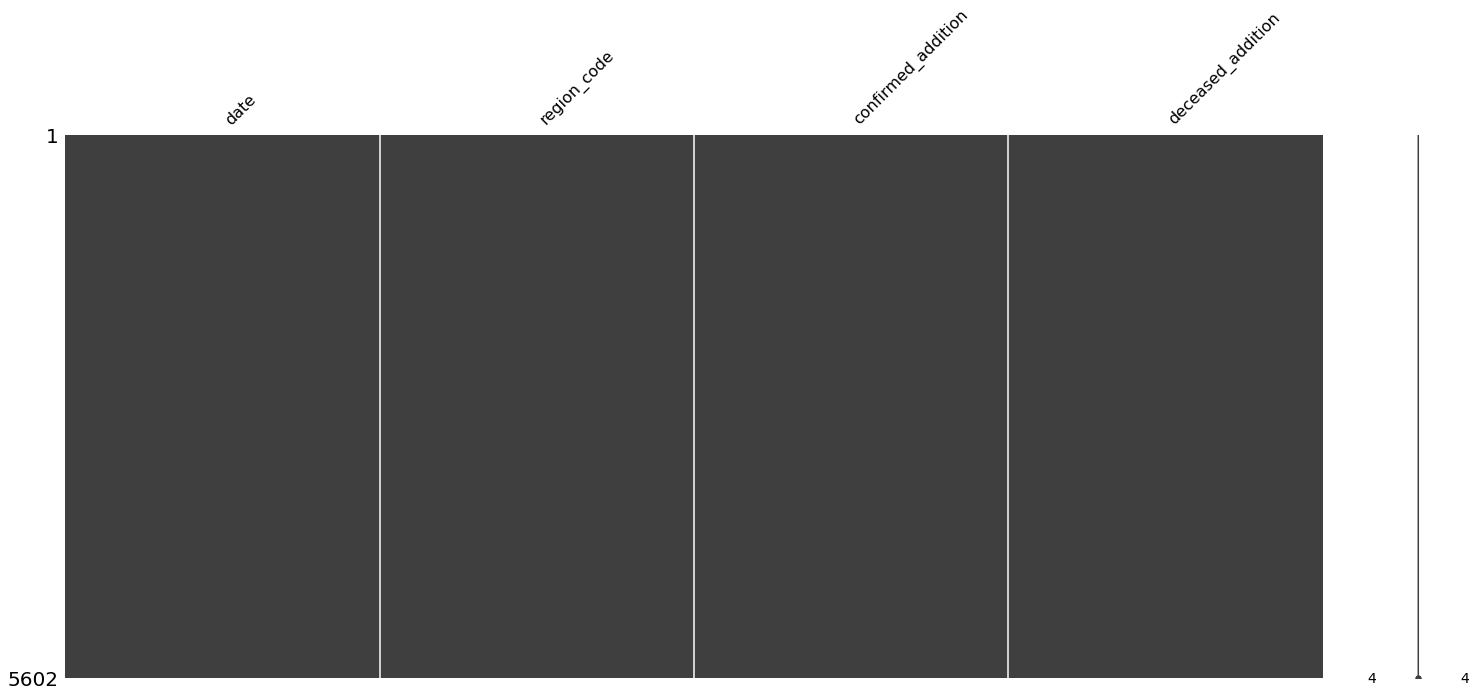

In [9]:
dataset_checker_values(raw_data['corona'],-999)

# Association Build-up

In [10]:
with open(meta, 'r',encoding = 'utf-8') as j:
     contents = json.loads(j.read())
country_metadata = pd.DataFrame(contents['country_metadata'])
sorted_country_metadata = country_metadata.sort_values(by = 'iso3166-2_name_en')
#a = pd.DataFrame(raw_data['corona'].value_counts())



#total  of covid cases per region
corona_by_region  = pd.DataFrame(raw_data['corona'].groupby(by = 'region_code').sum())
corona_by_region['iso3166-2_code'] = sorted_country_metadata['iso3166-2_code'].values
corona_by_region['population'] = sorted_country_metadata['population'].values
corona_by_region
    
#final_df

,confirmed_addition,deceased_addition,iso3166-2_code,population
region_code,,,,
Baden-Württemberg,311152,7940,DE-BW,11069533
Bayern,428996,12123,DE-BY,13076721
Berlin,126896,2728,DE-BE,3644826
Brandenburg,74955,2914,DE-BB,2511917
Bremen,17485,327,DE-HB,682986
Hamburg,50291,1223,DE-HH,1841179
Hessen,184434,5672,DE-HE,6265809
Mecklenburg-Vorpommern,23436,692,DE-MV,1609675
Niedersachsen,159191,4104,DE-NI,7982448


In [11]:
#similar to how Michele did
corona_df = raw_data['corona']
ss = dict()
for i in contents['country_metadata']:
    ss[i['covid_region_code']] = i['iso3166-2_code']
corona_df['region'] = corona_df['region_code'].map(ss)
corona_df

,date,region_code,confirmed_addition,deceased_addition,region
0,2020-01-02,Nordrhein-Westfalen,1,0,DE-NW
1,2020-01-07,Nordrhein-Westfalen,1,0,DE-NW
2,2020-01-09,Nordrhein-Westfalen,1,1,DE-NW
3,2020-01-12,Nordrhein-Westfalen,1,0,DE-NW
4,2020-01-14,Nordrhein-Westfalen,1,0,DE-NW
...,...,...,...,...,...
5597,2021-02-21,Rheinland-Pfalz,120,0,DE-RP
5598,2021-02-21,Sachsen,68,0,DE-SN
5599,2021-02-21,Sachsen-Anhalt,84,0,DE-ST
5600,2021-02-21,Schleswig-Holstein,113,0,DE-SH


In [12]:
daily_corona_weather = corona_df.merge(weather_data_de, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
daily_corona_weather = daily_corona_weather.drop(["date", "region_code", "region"], axis = 1)
daily_corona_weather

,confirmed_addition,deceased_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,1,0,DE-MV,69.818665,4.562424e+04,2.392858e+06,284.294049,0.004641,0.211216,7.888859
1,1,0,DE-BB,64.189273,9.007504e+05,2.409194e+06,282.312595,0.001005,2.631685,6.319781
2,1,0,DE-BB,71.904630,4.042940e+06,2.421421e+06,279.679468,0.002388,4.037911,6.150824
3,1,0,DE-NW,81.738535,1.064802e+06,2.383996e+06,279.663867,0.006802,3.524003,6.477330
4,1,0,DE-BW,80.314208,6.604918e+05,2.308155e+06,281.894530,0.005284,5.613589,4.663207
...,...,...,...,...,...,...,...,...,...,...
3994,193,1,DE-SL,87.575656,4.302501e+06,2.354934e+06,283.837352,0.000012,4.665761,3.050827
3995,1153,26,DE-SN,82.935273,2.388385e+06,2.362859e+06,283.909275,0.001199,2.795416,3.792073
3996,203,3,DE-ST,85.289489,1.447632e+06,2.407647e+06,284.662583,0.000446,1.478117,2.738335
3997,189,1,DE-SH,92.854723,7.043455e+05,2.429401e+06,283.769570,0.000243,0.033065,2.784840


In [13]:
weather_by_region = pd.DataFrame(weather_data_de.groupby(by = 'iso3166-2').mean())
weather_by_region

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
iso3166-2,,,,,,,
DE-BB,68.993457,8.306464e+06,2.419063e+06,286.418137,0.001714,20.031176,3.155209
DE-BE,66.852024,8.297034e+06,2.423727e+06,287.097292,0.001658,22.750127,3.563752
DE-BW,69.066944,9.646688e+06,2.305150e+06,286.115692,0.002608,24.421932,2.984610
DE-BY,71.789384,9.118904e+06,2.289241e+06,285.258091,0.002933,23.299714,2.694663
DE-HB,72.262570,8.220287e+06,2.433011e+06,286.478694,0.002214,20.926468,4.226105
DE-HE,69.103940,8.673261e+06,2.352639e+06,285.953385,0.001972,21.408103,3.310100
DE-HH,71.803334,8.334451e+06,2.428423e+06,286.105568,0.001963,21.081577,3.576606
DE-MV,73.631337,8.559347e+06,2.426495e+06,285.650888,0.001756,18.401257,3.669746
DE-NI,71.949725,8.273509e+06,2.416847e+06,286.066418,0.002169,20.092042,3.556017


In [43]:
weather_date = pd.to_datetime(weather_data_de['date'])
weather_month = pd.DataFrame(weather_data_de.groupby(weather_date.dt.month).mean())
weather_daily = pd.DataFrame(weather_data_de.groupby(weather_date).mean())
celsius = pd.DataFrame(weather_month['TemperatureAboveGround'].subtract(273.15))
weather_month['Temp_Celsius'] = celsius
#weather_daily

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
date,,,,,,,
2020-02-13,83.550416,9.232296e+05,2.361713e+06,276.080346,0.005425,3.045868,4.677214
2020-02-14,87.038057,1.189954e+06,2.385722e+06,277.740734,0.001314,1.875386,3.260335
2020-02-15,78.429711,2.849352e+06,2.388378e+06,279.481576,0.000151,3.958054,4.619486
2020-02-16,63.587472,7.130768e+05,2.360307e+06,284.575068,0.004384,3.224329,7.988258
2020-02-17,73.292063,1.628548e+06,2.373769e+06,280.940914,0.003836,3.951442,6.621854
...,...,...,...,...,...,...,...
2020-11-10,93.142306,1.180869e+06,2.408910e+06,278.386766,0.000058,1.032930,2.424941
2020-11-11,92.949727,3.166723e+05,2.403508e+06,279.602605,0.000346,0.473817,2.025096
2020-11-12,89.265265,1.284097e+06,2.390391e+06,280.757227,0.001018,1.994895,3.203011


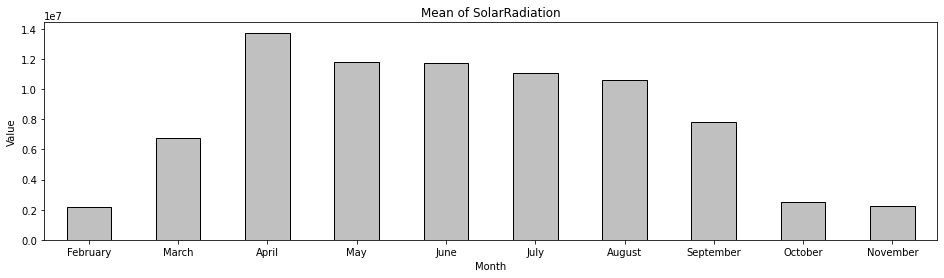

In [15]:
#function for plotting bar plots for weather
def weather_mean_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title('Mean of' + ' '+ column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

weather_mean_bar_plot('SolarRadiation',weather_month)

In [16]:
corona_date = pd.to_datetime(raw_data['corona']['date'])
corona_2020=pd.DataFrame(raw_data['corona'][corona_date.dt.year == 2020])
corona_month_sum = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).sum())
corona_month_mean = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).mean())
right_one = corona_month_sum[1:11]

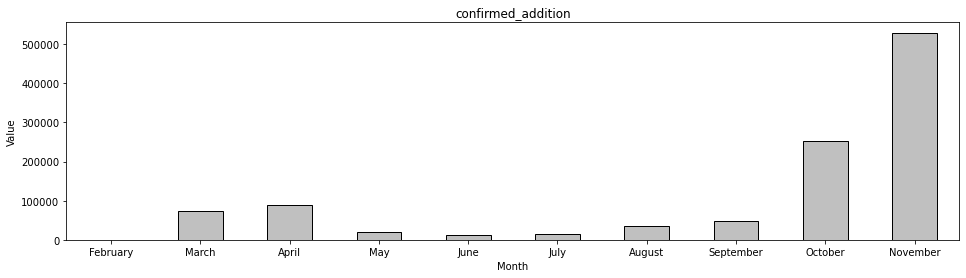

In [17]:
#function for plotting bar plots for corona infections
def corona_total_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)
corona_total_bar_plot('confirmed_addition',right_one)
#right_one

# Associations

In [18]:
#corona and weather conditions grouped by months
df_monthly_sum = corona_month_sum.merge(weather_month,left_on = 'date',right_on = 'date')
df_monthly_mean = corona_month_mean.merge(weather_month,left_on = 'date',right_on = 'date')

In [19]:
#pearson association for daily_corona_weather
weather_headers = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed'] #'Temp_Celsius']
significance_threshold = 0.001 / (len(weather_headers) * 3)
corrs = []
pvalues = []
for var in weather_headers:
    corr, pvalue = pearsonr(daily_corona_weather['confirmed_addition'], daily_corona_weather[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.215	3.345405599655828e-43	True

SolarRadiation
-0.222	1.0307206699161162e-45	True

Surfacepressure
-0.147	1.0903920091184766e-20	True

TemperatureAboveGround
-0.232	5.948712400201702e-50	True

Totalprecipitation
-0.012	0.4536698552904482	False

UVIndex
-0.334	1.2894296782571437e-104	True

WindSpeed
-0.047	0.0027023778964883087	False



In [20]:
#spearman assoctiation for daily_corona_weather
for var in weather_headers:
    corr, pvalue = spearmanr(daily_corona_weather['confirmed_addition'], daily_corona_weather[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.171	1.417493058453122e-27	True

SolarRadiation
-0.217	9.4163020278556e-44	True

Surfacepressure
-0.190	8.146635959751557e-34	True

TemperatureAboveGround
-0.325	3.418589611923137e-99	True

Totalprecipitation
-0.069	1.358237075993487e-05	True

UVIndex
-0.413	3.860162967020197e-164	True

WindSpeed
-0.082	2.034419872193119e-07	True



In [21]:
#logarithmic association for daily_corona_weather
for var in weather_headers:
    corr, pvalue = pearsonr(np.log(daily_corona_weather['confirmed_addition']), daily_corona_weather[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.169	6.294827545735649e-27	True

SolarRadiation
-0.217	5.958915240383062e-44	True

Surfacepressure
-0.205	4.843236365794755e-39	True

TemperatureAboveGround
-0.309	1.9845701754266657e-89	True

Totalprecipitation
-0.055	0.000564483962638577	False

UVIndex
-0.414	4.327914564879425e-165	True

WindSpeed
-0.073	3.983666462686262e-06	True



In [22]:
df = sm.add_constant(daily_corona_weather)
#weather_headers.extend("const")
est = sm.OLS(df["confirmed_addition"], df[weather_headers], hasconst = True).fit()
#print(est.summary())

In [23]:
est = sm.OLS(df["deceased_addition"], df[weather_headers], hasconst = True).fit()
#print(est.summary())


In [24]:
mask = (corona_df['date'] > "2020-11-02") & (corona_df['date'] <= "2021-03-07")
mask1 = (corona_df['date'] < "2020-11-02")
def corona_line_plot(df,x,y,title):
    ax = df.plot.line(x = x, y = y,rot = 45,figsize = (20,6),color = 'silver',title = title,ylabel = 'Corona Cases',xlabel = 'Date')

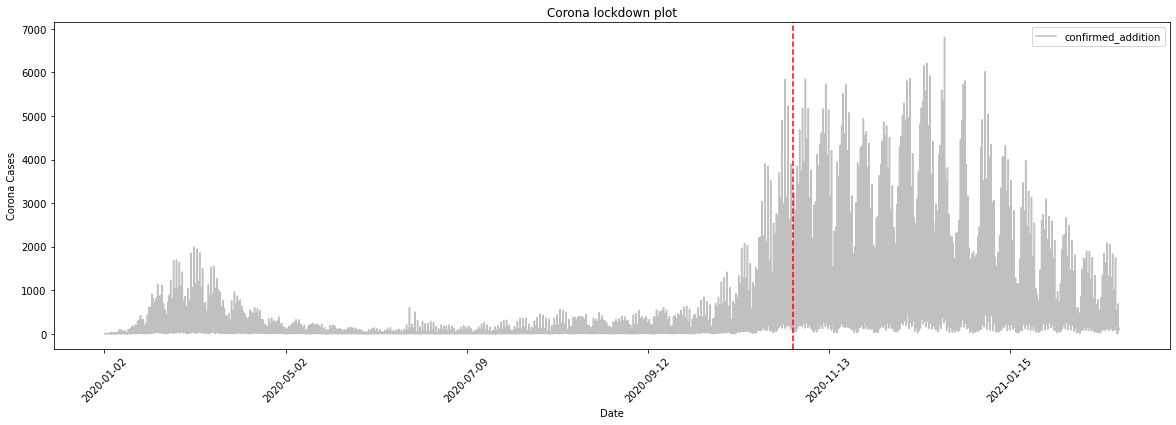

In [25]:
corona_line_plot(corona_df,'date','confirmed_addition','Corona lockdown plot')
plt.axvline(x=3800,color = 'red',ls = '--')

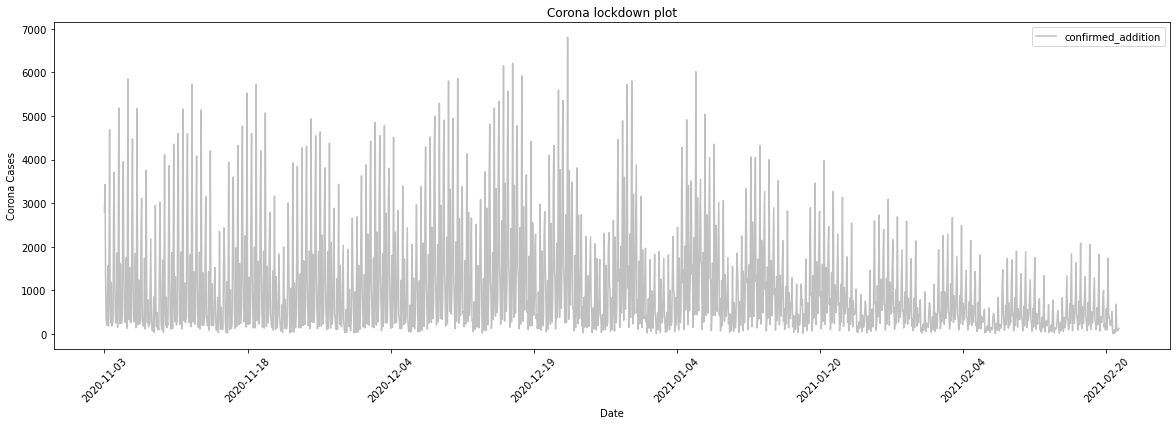

In [26]:
corona_line_plot(corona_df[mask],'date','confirmed_addition','Corona lockdown plot')

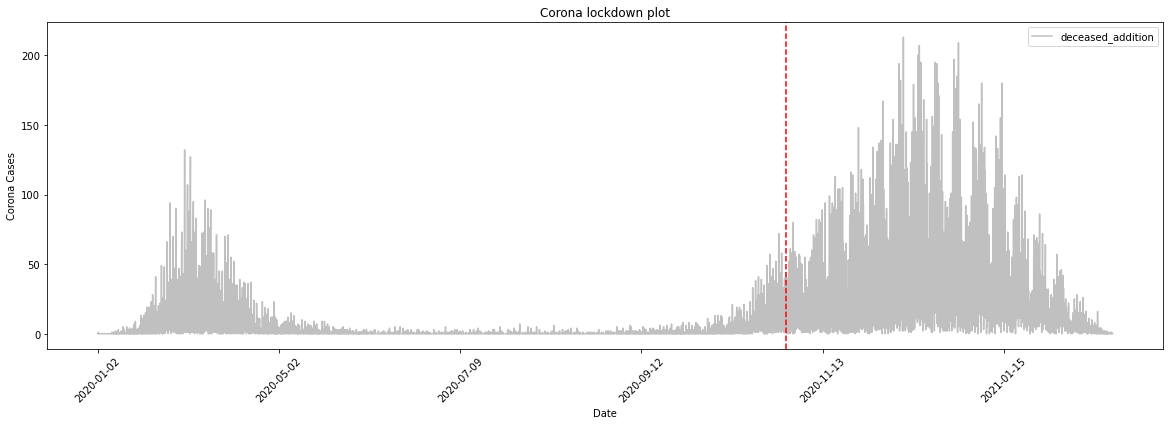

In [27]:
corona_line_plot(corona_df,'date','deceased_addition','Corona lockdown plot')
plt.axvline(x=3800,color = 'red',ls = '--')

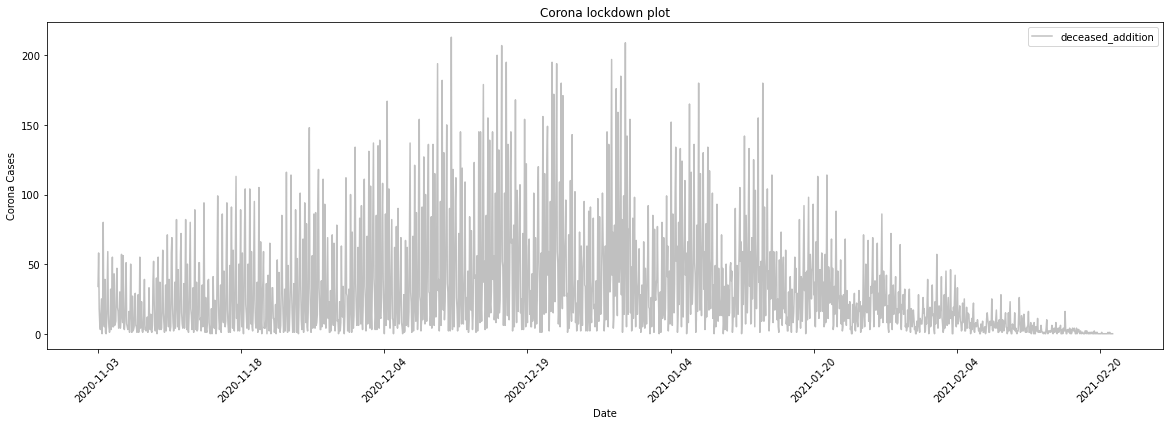

In [28]:
corona_line_plot(corona_df[mask],'date','deceased_addition','Corona lockdown plot')

In [29]:
corona_df['Lockdown'] = 'False'
corona_df.loc[(corona_df["date"] >= "2020-11-02") & (corona_df["date"] <= "2021-03-07"), "Lockdown"] = 'True'

In [30]:
daily_corona_weather

,confirmed_addition,deceased_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,1,0,DE-MV,69.818665,4.562424e+04,2.392858e+06,284.294049,0.004641,0.211216,7.888859
1,1,0,DE-BB,64.189273,9.007504e+05,2.409194e+06,282.312595,0.001005,2.631685,6.319781
2,1,0,DE-BB,71.904630,4.042940e+06,2.421421e+06,279.679468,0.002388,4.037911,6.150824
3,1,0,DE-NW,81.738535,1.064802e+06,2.383996e+06,279.663867,0.006802,3.524003,6.477330
4,1,0,DE-BW,80.314208,6.604918e+05,2.308155e+06,281.894530,0.005284,5.613589,4.663207
...,...,...,...,...,...,...,...,...,...,...
3994,193,1,DE-SL,87.575656,4.302501e+06,2.354934e+06,283.837352,0.000012,4.665761,3.050827
3995,1153,26,DE-SN,82.935273,2.388385e+06,2.362859e+06,283.909275,0.001199,2.795416,3.792073
3996,203,3,DE-ST,85.289489,1.447632e+06,2.407647e+06,284.662583,0.000446,1.478117,2.738335
3997,189,1,DE-SH,92.854723,7.043455e+05,2.429401e+06,283.769570,0.000243,0.033065,2.784840
